# 3.2 线性回归的简单实现


## 3.2.1 生成数据集

features: tensor([ 0.6013, -0.3121]) 
label: tensor([6.4605])


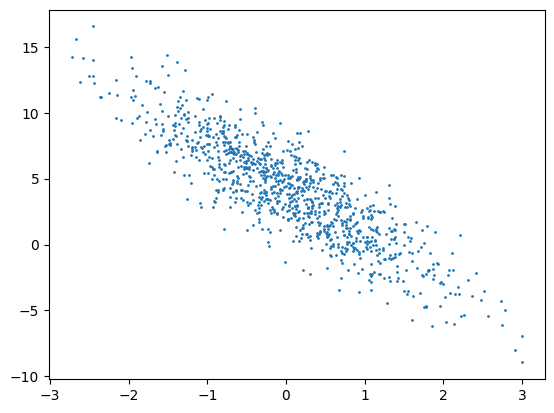

In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features[0],'\nlabel:', labels[0])
plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

## 3.2.2 读取数据集

In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = np.array(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-2.4260, -0.1691],
        [-2.0572,  1.8946],
        [-0.6723,  0.6083],
        [ 0.9020, -0.0392],
        [ 1.3948, -0.1125],
        [-0.5032,  0.1308],
        [ 1.6096,  0.7931],
        [ 1.1576, -1.2301],
        [-1.0754,  0.3189],
        [-1.6812,  2.3356]]) 
 tensor([[-0.0786],
        [-6.3633],
        [ 0.8016],
        [ 6.1359],
        [ 7.3715],
        [ 2.7499],
        [ 4.7193],
        [10.7121],
        [ 0.9633],
        [-7.0936]])


## 3.2.3 初始化模型参数
在我们开始用小批量随机梯度下降优化我们的模型参数之前， 我们需要先有一些参数。   
在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。   
在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。 每次更新都需要计算损失函数关于模型参数的梯度。 有了这个梯度，我们就可以向减小损失的方向更新每个参数。

In [ ]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 3.2.4 定义初始模型

In [ ]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

## 3.2.5 定义损失函数

In [ ]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 3.2.6 定义优化算法
在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。 接下来，朝着减少损失的方向更新我们的参数。

In [14]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 3.2.7 实现训练
在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。 计算完损失后，我们开始反向传播，存储每个参数的梯度。 最后，我们调用优化算法sgd来更新模型参数。

In [15]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.037131
epoch 2, loss 0.000141
epoch 3, loss 0.000049


In [16]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([5.5313e-04, 9.0837e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0003], grad_fn=<RsubBackward1>)
